In [206]:
# Load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler

import tensorflow as tf
from xgboost import XGBRegressor

In [207]:
# Set random seed for TensorFlow
tf.random.set_seed(123)

# Set random seed for Python
np.random.seed(123)

tf.keras.utils.set_random_seed(1)

tf.config.experimental.enable_op_determinism()

In [209]:
# Load data
data_all_county = pd.read_csv('data/CA_data_lat_log_weekly.csv')

# Extract month from the date as a feature
data_all_county['date'] = pd.to_datetime(data_all_county['date'])
data_all_county['month'] = data_all_county['date'].dt.month

# Processing Functions

In [125]:
def ts_multi_data_prep(dataset, target, start, end, window, step_out):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - step_out
        #end = len(dataset)
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i, i+step_out) #revise the window definition
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [126]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Evaluation metric results:-')
    mse = metrics.mean_squared_error(y_true.flatten(), y_pred.flatten())
    mae = metrics.mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mse)
    #mape = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten())
    r2 = metrics.r2_score(y_true.flatten(), y_pred.flatten())
    print(f'MSE is : {mse}')
    print(f'MAE is : {mae}')
    print(f'RMSE is : {rmse}')
    #print(f'MAPE is : {mape}')
    print(f'R2 is : {r2}\n')

In [127]:
def timeseries_evaluation_metrics_binary(y_true, y_pred):
    print('Evaluation metric results:-')
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    precision = precision_score(y_true.flatten(), y_pred.flatten(), average='macro')
    recall = recall_score(y_true.flatten(), y_pred.flatten(), average='macro')
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}\n')

In [131]:
def transform_county_data(x_data_array, y_data_array):
    # Lists to store x_train_c and y_train_c arrays
    x_c_list = []
    y_c_list = []
    # Divide the arrays into 'unique_fips_count' number of subarrays
    x_subarrays = np.array_split(x_data_array, unique_fips_count, axis=0)
    y_subarrays = np.array_split(y_data_array, unique_fips_count, axis=0)

    # Combine x_subarrays and y_subarrays into tuples
    data_tuples = [(x_subarray, y_subarray) for x_subarray, y_subarray in zip(x_subarrays, y_subarrays)]

    # Print or use the data tuples as needed
    for idx, data_tuple in enumerate(data_tuples):
        x_window_c, y_window_c = ts_multi_data_prep(data_tuple[0],data_tuple[1], 0, None, hist_window, step_out)
        # Append x_window_c and y_window_c arrays to lists
        x_c_list.append(x_window_c)
        y_c_list.append(y_window_c)

    # Stack arrays in lists to create x_train_c and y_train_c
    x_all_county = np.vstack(x_c_list)
    y_all_county = np.vstack(y_c_list)

    return x_all_county, y_all_county

# Data Processing

In [128]:
hist_window = 30
step_out = 12
x_train_c, y_train_c, x_vali_c, y_vali_c, x_test_c, y_test_c = [], [], [], [], [], []
unique_fips = data_all_county['fips'].unique()
unique_fips_count = data_all_county['fips'].nunique()
for fips in unique_fips:
    # Extract dataframe for the current FIPS value
    data_county = data_all_county[data_all_county['fips'] == fips]

    X_data = data_county[['lat','lon','PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score', 'month']]
    Y_data = data_county[['score']]
    #train_val_test split 70%-10%-20%
    n = len(X_data)

    x_train_county = X_data[0:int(n*0.7)]
    y_train_county = Y_data[0:int(n*0.7)]
    x_vali_county = X_data[int(n*0.7):int(n*0.8)]
    y_vali_county = Y_data[int(n*0.7):int(n*0.8)]
    x_test_county = X_data[int(n*0.8):]
    y_test_county = Y_data[int(n*0.8):]


    if fips == 6001:
        x_train_c, y_train_c, x_vali_c, y_vali_c, x_test_c, y_test_c = x_train_county, y_train_county, x_vali_county, y_vali_county, x_test_county, y_test_county

    else:
        x_train_c = np.concatenate((x_train_c, x_train_county), axis=0)
        y_train_c = np.concatenate((y_train_c, y_train_county), axis=0)
        x_vali_c = np.concatenate((x_vali_c, x_vali_county), axis=0)
        y_vali_c = np.concatenate((y_vali_c, y_vali_county), axis=0)
        x_test_c = np.concatenate((x_test_c, x_test_county), axis=0)
        y_test_c = np.concatenate((y_test_c, y_test_county), axis=0)


In [129]:
X_scaler_train = MinMaxScaler()
Y_scaler_train = MinMaxScaler()
X_scaler_test = MinMaxScaler()
Y_scaler_test = MinMaxScaler()
X_scaler_vali = MinMaxScaler()
Y_scaler_vali = MinMaxScaler()
x_train_data = X_scaler_train.fit_transform(x_train_c)
y_train_data = Y_scaler_train.fit_transform(y_train_c)
x_vali_data = X_scaler_vali.fit_transform(x_vali_c)
y_vali_data = Y_scaler_vali.fit_transform(y_vali_c)
x_test_data = X_scaler_test.fit_transform(x_test_c)
y_test_data = Y_scaler_test.fit_transform(y_test_c)

In [130]:
x_train_data.shape

(44486, 22)

In [132]:
x_train, y_train = transform_county_data(x_train_data, y_train_data)
x_vali, y_vali = transform_county_data(x_vali_data, y_vali_data)
x_test, y_test = transform_county_data(x_test_data, y_test_data)

In [133]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target\n')
print (y_train[0])

Multiple window of past history

[[5.29947117e-01 2.39715878e-01 2.92802021e-03 9.25820402e-01
  2.91703421e-01 3.93943140e-01 5.81672307e-01 5.74511770e-01
  3.60592630e-01 4.43743965e-01 3.41569163e-01 4.16622459e-01
  1.76152575e-01 2.16563083e-01 1.30602590e-01 2.49950070e-01
  2.20314920e-01 2.82671804e-01 1.43181818e-01 3.46506550e-01
  1.21580000e-01 0.00000000e+00]
 [5.29947117e-01 2.39715878e-01 2.85802090e-02 9.19918596e-01
  2.93541115e-01 4.06153001e-01 5.68814845e-01 5.62069488e-01
  3.85812222e-01 4.46299767e-01 3.92053216e-01 4.21354682e-01
  2.18351104e-01 2.93598508e-01 1.89077025e-01 3.03175554e-01
  2.74006195e-01 3.01805130e-01 2.41711230e-01 2.49606987e-01
  1.00720000e-01 0.00000000e+00]
 [5.29947117e-01 2.39715878e-01 1.04589224e-01 9.03841262e-01
  3.81064393e-01 4.46916632e-01 6.60853074e-01 6.54908788e-01
  3.91114563e-01 5.04884421e-01 2.81166479e-01 4.50917509e-01
  1.99579516e-01 3.13486638e-01 1.20683931e-01 4.17415618e-01
  2.65358802e-01 3.64192969e-01 1

In [134]:
print(x_train.shape)
print(y_train.shape)
print(x_vali.shape)
print(y_vali.shape)
print(x_test.shape)
print(y_test.shape)

(42050, 30, 22)
(42050, 12, 1)
(3886, 30, 22)
(3886, 12, 1)
(10324, 30, 22)
(10324, 12, 1)


In [135]:
# Convert all the 3D arrays to 2D for XGBoost
train_len = len(x_train)
num_features = X_data.shape[1]
vali_len = len(x_vali)
test_len = len(x_test)

# Reshape the labels into a simple 2D array
y_train = y_train.reshape(train_len, step_out)
y_vali = y_vali.reshape(vali_len, step_out)
y_test = y_test.reshape(test_len, step_out)

# Reshape the x data into a 2D array of (num windows, window size x features size)
x_train = x_train.reshape(train_len, hist_window * num_features)
x_vali = x_vali.reshape(vali_len, hist_window * num_features)
x_test = x_test.reshape(test_len, hist_window * num_features)

In [136]:
print(x_train.shape)
print(y_train.shape)
print(x_vali.shape)
print(y_vali.shape)
print(x_test.shape)
print(y_test.shape)

(42050, 660)
(42050, 12)
(3886, 660)
(3886, 12)
(10324, 660)
(10324, 12)


# Model

In [137]:
# xgboost parameters - https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster

learning_rate = 0.15 # tutorial suggests learning rate of 0.1 or lower
max_depth = 3 # tutorial suggests 2 to 8, default is 6
subsample = 1 # range 0-1, percent of training to randomly sample during boosting

In [138]:
def xgboost_forecast(x_train, y_train, x_test):
    # fit the model
    model = XGBRegressor(objective='reg:squarederror',
                         n_estimators=100,
                         max_depth = max_depth,
                         learning_rate = learning_rate)
    model.fit(x_train, y_train)

    feature_imp = model.feature_importances_

    # predict
    yhat = model.predict(x_test)
    return yhat, feature_imp

In [139]:
y_vali_pred, vali_feature_imp = xgboost_forecast(x_train, y_train, x_vali)

In [140]:
y_test_pred, feature_imp = xgboost_forecast(x_train, y_train, x_test)

# Model Evaluation

## Validation Dataset

In [24]:
# Apply inverse transform
y_vali_pred_Inverse = Y_scaler_vali.inverse_transform(y_vali_pred)
y_vali_pred_Inverse_ordinal = np.round(y_vali_pred_Inverse).astype(int)
y_vali_Inverse = Y_scaler_vali.inverse_transform(y_vali)
y_vali_Inverse_ordinal = np.round(y_vali_Inverse).astype(int)

In [25]:
# Direct actual vs. predicted score comparison
timeseries_evaluation_metrics_func(y_vali_Inverse,y_vali_pred_Inverse)


Evaluation metric results:-
MSE is : 0.5329970226716245
MAE is : 0.49377111263381646
RMSE is : 0.7300664508602107
R2 is : 0.6402766053442356



In [26]:
# Actual vs. predicted score comparison if scores were integers 0-5
timeseries_evaluation_metrics_func(y_vali_Inverse_ordinal,y_vali_pred_Inverse_ordinal)


Evaluation metric results:-
MSE is : 0.6667738891748156
MAE is : 0.4766040487219077
RMSE is : 0.8165622383963244
R2 is : 0.5857460617357714



Text(0.5, 1.0, 'Distribution of Actual Validation Drought Scores')

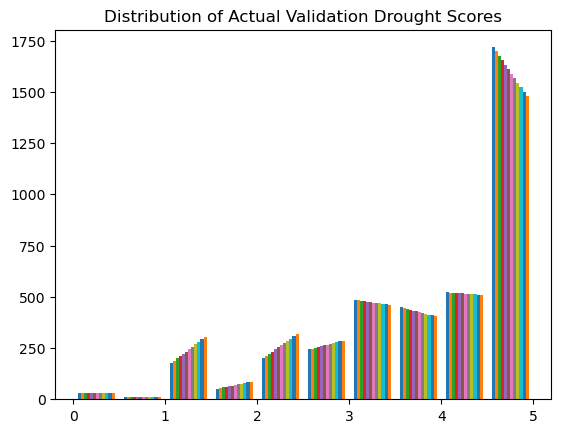

In [27]:
plt.hist(y_vali_Inverse)
plt.title('Distribution of Actual Validation Drought Scores')

Text(0.5, 1.0, 'Distribution of Predicted Validation Drought Scores')

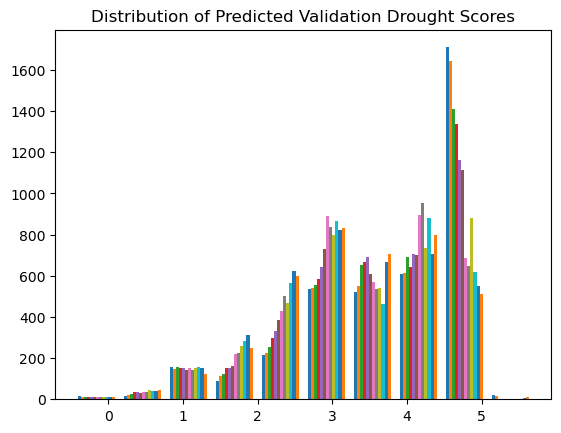

In [28]:
plt.hist(y_vali_pred_Inverse)
plt.title('Distribution of Predicted Validation Drought Scores')

## Test Dataset

In [141]:
# Apply inverse transform
y_test_pred_Inverse = Y_scaler_test.inverse_transform(y_test_pred)
y_test_pred_Inverse_ordinal = np.round(y_test_pred_Inverse).astype(int)
y_test_Inverse = Y_scaler_test.inverse_transform(y_test)
y_test_Inverse_ordinal = np.round(y_test_Inverse).astype(int)

In [142]:
# Direct actual vs. predicted score comparison
timeseries_evaluation_metrics_func(y_test_Inverse,y_test_pred_Inverse)

Evaluation metric results:-
MSE is : 0.29648042698318855
MAE is : 0.34998273420429293
RMSE is : 0.5445001625189735
R2 is : 0.725223714634252



In [143]:
# Actual vs. predicted score comparison if scores were integers 0-5
timeseries_evaluation_metrics_func(y_test_Inverse_ordinal,y_test_pred_Inverse_ordinal)

Evaluation metric results:-
MSE is : 0.38493639416246933
MAE is : 0.3115798140255715
RMSE is : 0.6204324251378786
R2 is : 0.6650983070604055



Text(0.5, 1.0, 'Distribution of Actual Test Drought Scores')

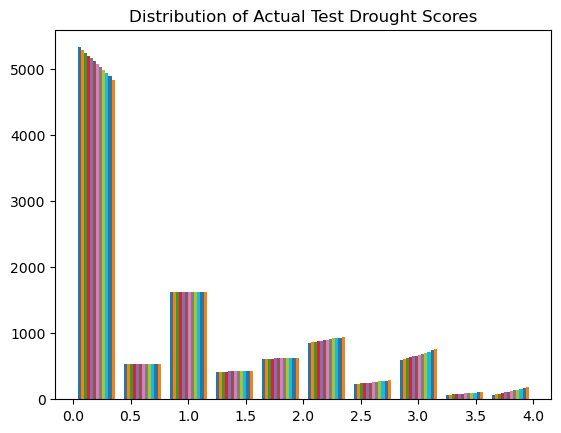

In [144]:
plt.hist(y_test_Inverse)
plt.title('Distribution of Actual Test Drought Scores')

Text(0.5, 1.0, 'Distribution of Predicted Test Drought Scores')

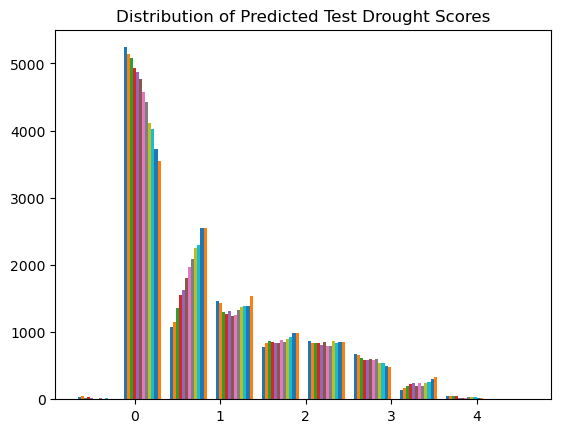

In [145]:
plt.hist(y_test_pred_Inverse)
plt.title('Distribution of Predicted Test Drought Scores')

## Test - Multiclass Classification Evaluation

In [204]:
def multiclass_eval_results(actual, preds):
    '''Takes the ordinal/integer form of the actual and predicted scores and 
    returns a df with the accuracy for each score, overprediction percent, and undeprediction percent
    and prints classification report'''

    # Create dictionary to set up df
    df_dict = {'true_score': actual.flatten(),
                'pred_score': preds.flatten()}

    mc_df = pd.DataFrame(data = df_dict)
    
    # create cols for calculating accuracy, overprediction, and underprediction by score
    mc_df['accurate_count'] = np.where(mc_df['true_score'] == mc_df['pred_score'], 1, 0)
    mc_df['overpred_count'] = np.where(mc_df['pred_score'] > mc_df['true_score'], 1, 0)
    mc_df['underpred_count'] = np.where(mc_df['pred_score'] < mc_df['true_score'], 1, 0)

    # groupby to aggregate
    df = mc_df.groupby('true_score').sum('accurate_count')

    # get subtotal columns
    df['actual_totals'] = mc_df['true_score'].value_counts()
    df['incorrect_total'] = df['overpred_count'] + df['underpred_count']

    # calculate percents
    df['accuracy_rate'] = df['accurate_count'] / df['actual_totals']
    df['overpred_perc'] = df['overpred_count'] / df['incorrect_total']
    df['underpred_perc'] = df['underpred_count'] / df['incorrect_total']

    # rearrange order of columns
    df_cols = list(df.columns)
    df_cols = [
        'accuracy_rate', 'overpred_perc', 'underpred_perc',
        'actual_totals','pred_score',
        'accurate_count','overpred_count','underpred_count','incorrect_total']
    df = df[df_cols]

    # rename for more accurate col name
    df.rename(columns = {'pred_score': 'pred_totals'}, inplace = True)
    
    print('Overall Accuracy Rate:', round(accuracy_score(actual.flatten(), preds.flatten()), 4))
    print()
    print('Classification Report')
    print(classification_report(actual.flatten(), 
                                preds.flatten(),
                                labels = [0,1,2,3,4,5],
                                target_names = ['None - 0', 'Dry - 1', 'Moderate - 2',
                                       'Severe - 3', 'Extreme - 4', 'Exceptional - 5']))

    return df

In [205]:
mc_results_df = multiclass_eval_results(y_test_Inverse_ordinal.flatten(), y_test_pred_Inverse_ordinal.flatten())

mc_results_df

Overall Accuracy Rate: 0.7231

Classification Report
                 precision    recall  f1-score   support

       None - 0       0.84      0.83      0.83     62868
        Dry - 1       0.53      0.63      0.58     27792
   Moderate - 2       0.64      0.61      0.62     20118
     Severe - 3       0.78      0.66      0.71     11363
    Extreme - 4       0.68      0.23      0.34      1747
Exceptional - 5       0.00      0.00      0.00         0

      micro avg       0.72      0.72      0.72    123888
      macro avg       0.58      0.49      0.51    123888
   weighted avg       0.73      0.72      0.72    123888



/Users/angelachang/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/angelachang/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/angelachang/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy_rate,overpred_perc,underpred_perc,actual_totals,pred_totals,accurate_count,overpred_count,underpred_count,incorrect_total
true_score,,,,,,,,,
0,0.826160,0.999451,0.000549,62868,12150,51939,10923,6,10929
1,0.630577,0.256940,0.743060,27792,23019,17525,2638,7629,10267
2,0.610001,0.106551,0.893449,20118,32174,12272,836,7010,7846
3,0.655285,0.027317,0.972683,11363,29725,7446,107,3810,3917
4,0.228964,0.000000,1.000000,1747,5410,400,0,1347,1347


## Test - Binary Classification Evaluation

In [73]:
def binary_class_eval(threshold, actual, preds):
    y_test_Inverse_binary = np.where(actual >= threshold, 1, 0)
    y_test_pred_Inverse_binary = np.where(preds >= threshold, 1, 0)
    
    timeseries_evaluation_metrics_binary(y_test_Inverse_binary,y_test_pred_Inverse_binary)

    # Compute classification report
    classification_metrics = classification_report(y_test_Inverse_binary.flatten(),y_test_pred_Inverse_binary.flatten())
    #classification_metrics = classification_report(y_test_Inverse_ordinal.flatten(),y_test_pred_Inverse_ordinal.flatten())
    # Print classification report
    print()
    print('Classification Report')
    print(classification_metrics)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test_Inverse_binary.flatten(), y_test_pred_Inverse_binary.flatten())

    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()

### Using 0.5 as "Any Drought" Score

A score of 1 is considered abnormally dry. A score of 0.5 would be rounded up to 1.

Evaluation metric results:-
Accuracy: 0.8341405140126565
Precision: 0.8341956769665235
Recall: 0.834256465264299
F1-score: 0.8341372923834616


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83     62856
           1       0.82      0.84      0.83     61032

    accuracy                           0.83    123888
   macro avg       0.83      0.83      0.83    123888
weighted avg       0.83      0.83      0.83    123888

Confusion Matrix:
[[51943 10913]
 [ 9635 51397]]


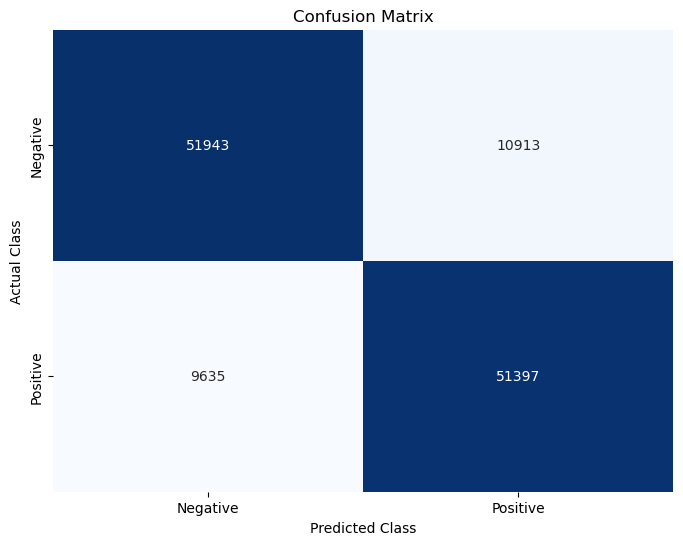

In [75]:
binary_class_eval(0.5, y_test_Inverse, y_test_pred_Inverse)

### Using 1.5 as "Moderate" Score

A score of 2 is considered Moderate drought. A score of 1.5 would be rounded up to 2.

Evaluation metric results:-
Accuracy: 0.9077473201601447
Precision: 0.8949776606065709
Recall: 0.8642734130520877
F1-score: 0.877896823013569


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     90660
           1       0.87      0.77      0.82     33228

    accuracy                           0.91    123888
   macro avg       0.89      0.86      0.88    123888
weighted avg       0.91      0.91      0.91    123888

Confusion Matrix:
[[86857  3803]
 [ 7626 25602]]


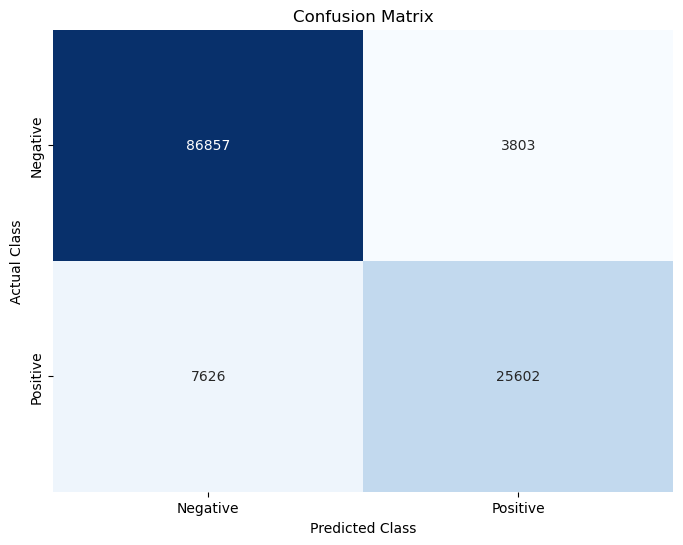

In [76]:
binary_class_eval(1.5, y_test_Inverse, y_test_pred_Inverse)

### Using 2.5 as "Severe" Drought Classification

Evaluation metric results:-
Accuracy: 0.9590920831718972
Precision: 0.9300147809942136
Recall: 0.8425569964015276
F1-score: 0.8798821947216257


Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    110778
           1       0.90      0.69      0.78     13110

    accuracy                           0.96    123888
   macro avg       0.93      0.84      0.88    123888
weighted avg       0.96      0.96      0.96    123888

Confusion Matrix:
[[109712   1066]
 [  4002   9108]]


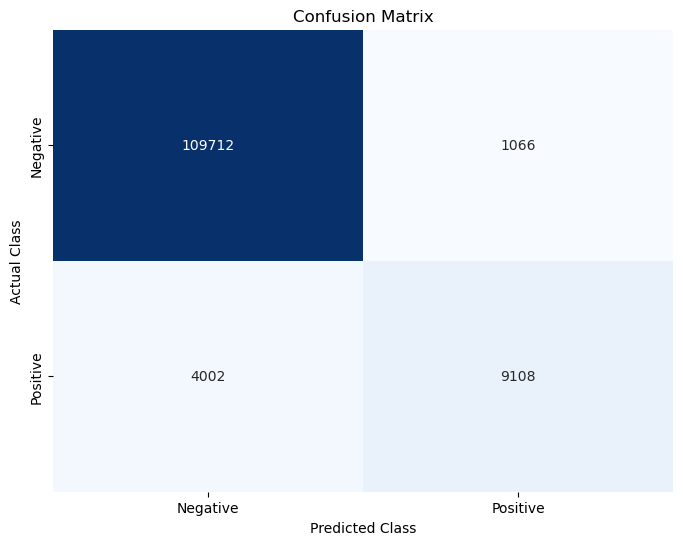

In [77]:
binary_class_eval(2.5, y_test_Inverse, y_test_pred_Inverse)

### Using Extreme Drought as Threshold - 3.5

Extreme Drought is a score of 4. Scores at 3.5 or higher will round up to 4.

Evaluation metric results:-
Accuracy: 0.9875694175384218
Precision: 0.8318056195443455
Recall: 0.6136918985975685
F1-score: 0.6678028968646482


Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    122141
           1       0.67      0.23      0.34      1747

    accuracy                           0.99    123888
   macro avg       0.83      0.61      0.67    123888
weighted avg       0.98      0.99      0.98    123888

Confusion Matrix:
[[121948    193]
 [  1347    400]]


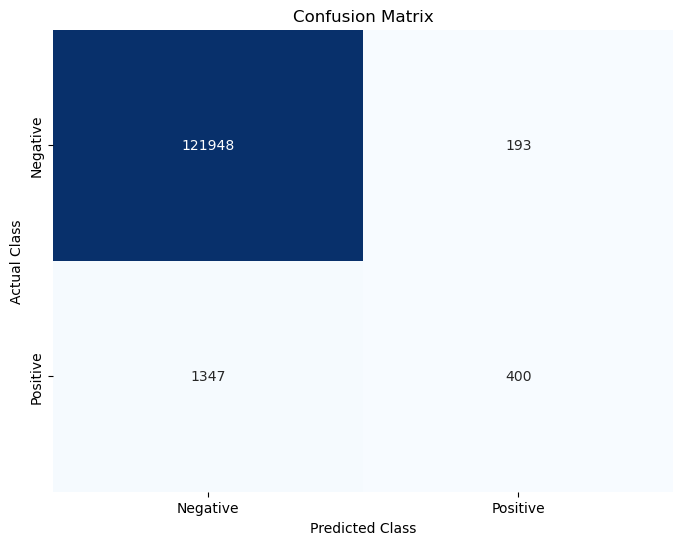

In [78]:
binary_class_eval(3.5, y_test_Inverse, y_test_pred_Inverse)

# Feature Importance

In [40]:
feature_imp

array([7.68324942e-04, 1.09661242e-03, 9.71708854e-04, 7.78724963e-04,
       1.00703468e-03, 8.24191666e-04, 6.79822522e-04, 6.66238833e-04,
       2.07605748e-03, 2.43513868e-03, 1.04707759e-03, 3.78950872e-03,
       1.27698993e-04, 3.10336909e-04, 1.34096842e-03, 1.56755370e-04,
       0.00000000e+00, 3.02991510e-04, 5.32730250e-04, 2.14393192e-04,
       2.38704332e-03, 3.76697117e-03, 0.00000000e+00, 0.00000000e+00,
       1.38736912e-03, 8.33220383e-06, 9.42753803e-04, 1.52325293e-03,
       1.45178661e-03, 0.00000000e+00, 6.96968171e-04, 8.92800395e-04,
       1.33959379e-03, 3.22380831e-04, 2.35875297e-04, 4.15371702e-04,
       1.99406364e-04, 2.91670061e-04, 5.84796770e-04, 3.22948210e-04,
       4.31271968e-04, 9.34607306e-05, 1.92971132e-03, 6.01396896e-03,
       0.00000000e+00, 0.00000000e+00, 2.16708239e-03, 1.20553793e-03,
       9.79864970e-04, 1.73317397e-03, 1.48393039e-03, 8.92307653e-05,
       1.60452130e-03, 0.00000000e+00, 5.33143117e-04, 7.42520788e-04,
      

In [41]:
feature_imp.shape

(660,)

In [42]:
630 / 21

30.0

In [43]:
feature_imp.shape[0] / num_features

30.0

In [44]:
def get_features_sum(num_windows, num_features, features_ar):
    # Reshape the features to aggregate the feature importances
    features_ar = np.reshape(features_ar, [num_windows, num_features])

    feature_df = pd.DataFrame(data = features_ar,
                      columns = ['lat','lon','PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score', 'month'])

    print(feature_df.sum())

In [45]:
get_features_sum(int(feature_imp.shape[0] / num_features), num_features, feature_imp)


lat            0.000768
lon            0.001097
PRECTOT        0.051974
PS             0.021763
QV2M           0.046246
T2M            0.034056
T2MDEW         0.032309
T2MWET         0.031222
T2M_MAX        0.036907
T2M_MIN        0.037579
T2M_RANGE      0.040055
TS             0.061775
WS10M          0.020136
WS10M_MAX      0.018703
WS10M_MIN      0.008525
WS10M_RANGE    0.021550
WS50M          0.014036
WS50M_MAX      0.018349
WS50M_MIN      0.007471
WS50M_RANGE    0.009933
score          0.272987
month          0.212558
dtype: float32
